# 91APP 資料清理、視覺化

## 目錄:

* Orders.csv訂單資料集

* Orders.csv訂單合併

* ShoppingCarts.csv共變異數矩陣

    * 不同付款方式與不同使用平台，與總價格的關係
    
    * 不同付款方式與不同使用平台，與總數量的關係
    
    * 不同付款方式與不同使用裝置，與總價格的關係
 
    * 不同付款方式與不同使用裝置，與總數量的關係
  
    * 總價格與總數量的關係

* ShoppingCarts.csv每月總營收

* ShoppingCarts.csv週間訂單數

* PromotionOrders.csv與TargetOrders.csv合併、清理、視覺化

    * 各優惠折扣歷史總使用次數

    * 各優惠折扣每月使用次數


In [2]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
pd.set_option('display.max_columns', None)
plotly.tools.set_credentials_file(username='jacky920236', api_key='MWEVmNLzns7pkjvXDWHU')


In [3]:
# Overview data function
def describe_pd_data(pd_data):
    print("Data columns:")
    print(pd_data.info())
    print("__________________________________________________________________")
    print("Data head:")
    print(pd_data.head())
    print("__________________________________________________________________")
    print("Data length:")
    print(len(pd_data))
    

## Orders.csv訂單資料清理

* 取出有效訂單 (`IsMajor == True`, `IsGift == False`, `IsSalePageGift == False`, `StatusDef == Finish`)

* 取出有效城市名稱

* 依照下單時間排序資料

原資料集共有5,495,276筆訂單資料，經過以上篩選流程後剩餘4,080,742筆


In [3]:
# Load data
order = pd.read_csv("./Dataset/Orders.csv", dtype="unicode")
describe_pd_data(order)


Data columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
DateId                         object
MemberId                       object
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              object
SalePageId                     object
IsMajor                        object
IsGift                         object
IsSalePageGift                 object
Quantity                       object
UnitPrice                      object
PromotionDiscount              object
ECouponId                      object
ECouponDiscount                object
SalesOrderSlaveTotalPayment    object
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           object
City                           object
District                       object
ZipCode                        object
StoreName                      object

In [ ]:
# Select main product and complete order only
target_order = order.loc[(order["IsMajor"] == "True") & (order["IsGift"] == "False") & (order["IsSalePageGift"] == "False") & (order["StatusDef"] == "Finish")]
target_order = target_order.drop(columns=["IsMajor", "IsGift", "IsSalePageGift", "StatusDef"])

# Drop invalid city names
target_order = target_order.loc[(target_order["City"] != "<fo") & (target_order["City"] != "1st") & (target_order["City"] != "Tao") & (target_order["City"] != "New") & (target_order["City"] != "Kao")]

# Columns to datetime
target_order["DateId"] = pd.to_datetime(target_order["DateId"].astype(str), format="%Y%m%d")
target_order["SalesOrderSlaveDateTime"] = pd.to_datetime(target_order["SalesOrderSlaveDateTime"].astype(str), format="%Y-%m-%d %H:%M:%S.%f")

# Sort by datetime
target_order = target_order.sort_values(by=["DateId"])

# Cleaned data overview
describe_pd_data(target_order)

# Save cleaned data
target_order.to_csv("./Dataset/TargetOrders.csv", sep=",", encoding="utf-8", index=False)


In [10]:
target_order = pd.read_csv("./Dataset/TargetOrders.csv", dtype="unicode")
describe_pd_data(target_order)


Data columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080742 entries, 0 to 4080741
Data columns (total 24 columns):
DateId                         object
MemberId                       object
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              object
SalePageId                     object
Quantity                       object
UnitPrice                      object
PromotionDiscount              object
ECouponId                      object
ECouponDiscount                object
SalesOrderSlaveTotalPayment    object
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           object
City                           object
District                       object
ZipCode                        object
StoreName                      object
StoreId                        object
DeliverTypeDef                 object
ReturnGoodsDateId              object

## Orders.csv訂單合併

* 將同屬一個購物車 `OrderGroupCode` 的訂單合併

    * 價格 `SalesOrderSlaveTotalPayment` 加總
    
    * 數量 `Quantity` 加總
    
    * 優惠券折扣代碼 `ECouponId` 提取
    
    * 優惠券折扣金額 `ECouponDiscount` 加總

* 排除離群值
    
    * 總價格 `SalesOrderSlaveTotalPayment` 不超過5,000元
    
    * 總數量 `Quantity` 不超過12件商品

原資料集共有4,080,742筆訂單資料，經過以上合併與篩選流程後剩餘1,024,634筆，並將新資料另存為 `ShoppingCarts.csv`


In [ ]:
# Columns to numeric
target_order[["SalesOrderSlaveTotalPayment","Quantity","PromotionDiscount","ECouponDiscount"]] = target_order[["SalesOrderSlaveTotalPayment","Quantity","PromotionDiscount","ECouponDiscount"]].apply(pd.to_numeric)

# Group each target order together by OrderGroupCode
agg_key = {"SalesOrderSlaveTotalPayment": "sum", "Quantity": "sum", "PromotionDiscount": "sum", "ECouponId": "first", "ECouponDiscount": "sum"}
shopping_cart = target_order.groupby("OrderGroupCode", as_index=False).agg(agg_key)

# Drop duplicated columns
target_order = target_order.drop(columns=["SalesOrderSlaveTotalPayment","Quantity","PromotionDiscount","ECouponId","ECouponDiscount","UnitPrice"])

# Merge groupby data back to original data
shopping_cart = shopping_cart.merge(target_order.groupby("OrderGroupCode", as_index=False).nth(0), on=["OrderGroupCode"], how="left")

# Grouped full data overview
describe_pd_data(shopping_cart)

# Save grouped data (Each row is a cart)
shopping_cart.to_csv("./Dataset/ShoppingCarts.csv", sep=",", encoding="utf-8", index=False)


In [4]:
shopping_cart = pd.read_csv("./Dataset/ShoppingCarts.csv", dtype="unicode")
shopping_cart[["SalesOrderSlaveTotalPayment","Quantity"]] = shopping_cart[["SalesOrderSlaveTotalPayment","Quantity"]].apply(pd.to_numeric)
shopping_cart = shopping_cart.loc[(shopping_cart["SalesOrderSlaveTotalPayment"] <= 5000) & (shopping_cart["Quantity"] <= 12)]
shopping_cart["DateId"] = pd.to_datetime(shopping_cart["DateId"].astype(str), format="%Y-%m-%d")
shopping_cart["SalesOrderSlaveDateTime"] = pd.to_datetime(shopping_cart["SalesOrderSlaveDateTime"].astype(str), format="%Y-%m-%d %H:%M:%S.%f")

describe_pd_data(shopping_cart)


Data columns:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024634 entries, 0 to 1037352
Data columns (total 24 columns):
OrderGroupCode                 1024634 non-null object
SalesOrderSlaveTotalPayment    1024634 non-null float64
Quantity                       1024634 non-null int64
PromotionDiscount              1024634 non-null object
ECouponId                      1024634 non-null object
ECouponDiscount                1024634 non-null object
DateId                         1024634 non-null datetime64[ns]
MemberId                       1024634 non-null object
TrackSourceTypeDef             1024634 non-null object
TrackDeviceTypeDef             1024634 non-null object
PayProfileTypeDef              1024634 non-null object
SalesOrderSlaveId              1024634 non-null object
SalePageId                     1024634 non-null object
UnitPrice                      1024634 non-null object
SalesOrderSlaveDateTime        1024634 non-null datetime64[ns]
SalesOrderReceiverId           1

## ShoppingCarts.csv共變異數矩陣

* 連續型變數
    
    * 總價格 `SalesOrderSlaveTotalPayment`
    
    * 總數量 `Quantity`
    
    * 促銷折扣金額 `PromotionDiscount`
    
    * 優惠券折扣金額 `ECouponDiscount`
    
* 離散型變數

    * 使用平台 `TrackSourceTypeDef`
    
    * 使用裝置 `TrackDeviceTypeDef`
    
    * 付款方式 `PayProfileTypeDef`
    
    * 城市 `City`
    
    * 取貨方式 `DeliverTypeDef`
    
* 根據共變異數矩陣，可延伸出以下探討範疇
    
    * 不同付款方式與不同使用平台，與總價格的關係
    
    * 不同付款方式與不同使用平台，與總數量的關係
    
    * 不同付款方式與不同使用裝置，與總價格的關係
    
    * 不同付款方式與不同使用裝置，與總數量的關係
    
    * 總價格與總數量的關係

Data columns:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024634 entries, 0 to 1037352
Data columns (total 12 columns):
SalesOrderSlaveTotalPayment    1024634 non-null float64
Quantity                       1024634 non-null int64
PromotionDiscount              1024634 non-null float64
ECouponDiscount                1024634 non-null float64
DateId                         1024634 non-null datetime64[ns]
TrackSourceTypeDef             1024634 non-null int8
TrackDeviceTypeDef             1024634 non-null int8
PayProfileTypeDef              1024634 non-null int8
UnitPrice                      1024634 non-null object
SalesOrderSlaveDateTime        1024634 non-null datetime64[ns]
City                           1024634 non-null int8
DeliverTypeDef                 1024634 non-null int8
dtypes: datetime64[ns](2), float64(3), int64(1), int8(5), object(1)
memory usage: 67.4+ MB
None
__________________________________________________________________
Data head:
   SalesOrderSlaveTotalPayment 

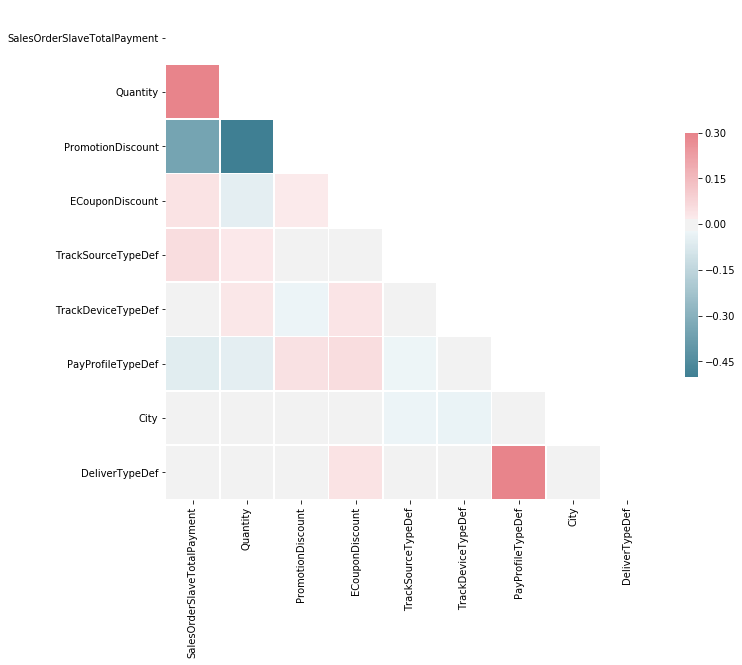

In [8]:
categorized_data = shopping_cart.copy()
categorized_data[["SalesOrderSlaveTotalPayment","Quantity","PromotionDiscount","ECouponDiscount"]] = categorized_data[["SalesOrderSlaveTotalPayment","Quantity","PromotionDiscount","ECouponDiscount"]].apply(pd.to_numeric)
categorized_data = categorized_data.drop(columns=["OrderGroupCode","ECouponId","MemberId","SalesOrderSlaveId","SalePageId","SalesOrderReceiverId","StoreName","StoreId","District","ZipCode","ReturnGoodsDateId","CauseDef"])
cat_code = ["TrackSourceTypeDef","TrackDeviceTypeDef","PayProfileTypeDef","City","DeliverTypeDef"]
for col in cat_code:
    categorized_data[col] = pd.Categorical(categorized_data[col])
    categorized_data[col] = categorized_data[col].cat.codes
describe_pd_data(categorized_data)

corr_matrix = categorized_data.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


## 不同付款方式與不同使用平台，與總價格的關係

* 使用`iOSApp`消費的顧客每次購物的金額大於其他平台使用者，`AndroidApp`次之，`Web`居末

* 高總價的訂單與`ATM`付款呈現相關性

* 總價格比較: `ATM` > `CreditCard` > `LinePay` > `SevenEleven` = `Family`

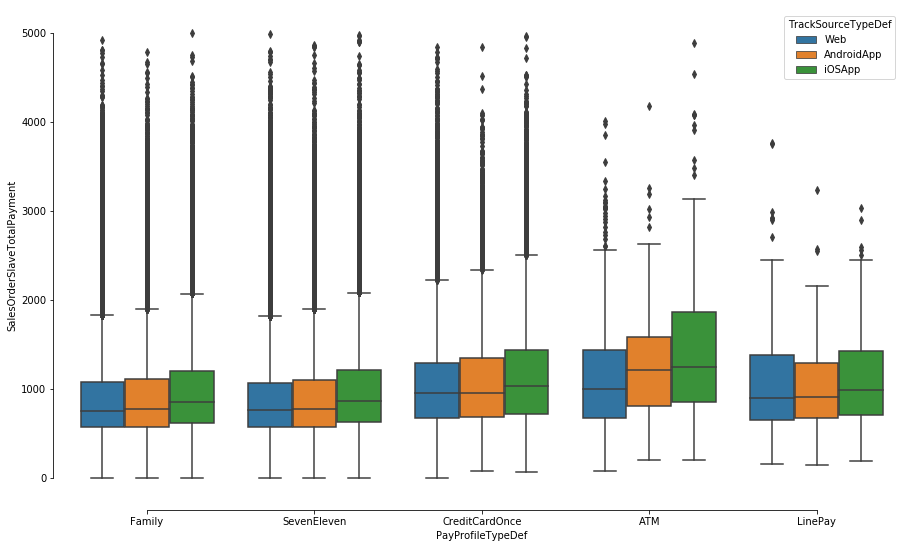

In [33]:
f, ax = plt.subplots(figsize=(15, 9))
sns.boxplot(x="PayProfileTypeDef", y="SalesOrderSlaveTotalPayment",
            hue="TrackSourceTypeDef", data=shopping_cart)
sns.despine(offset=10, trim=True)


## 不同付款方式與不同使用平台，與總數量的關係

* 不同平台的顧客在購買商品數量的差異較不明顯，使用`iOSApp`消費的顧客購買數量稍多於其他平台使用者

* 多商品數量的訂單與`ATM`付款呈現相關性

* 總商品數量比較: `ATM` > `CreditCard` > `LinePay` > `SevenEleven` = `Family`

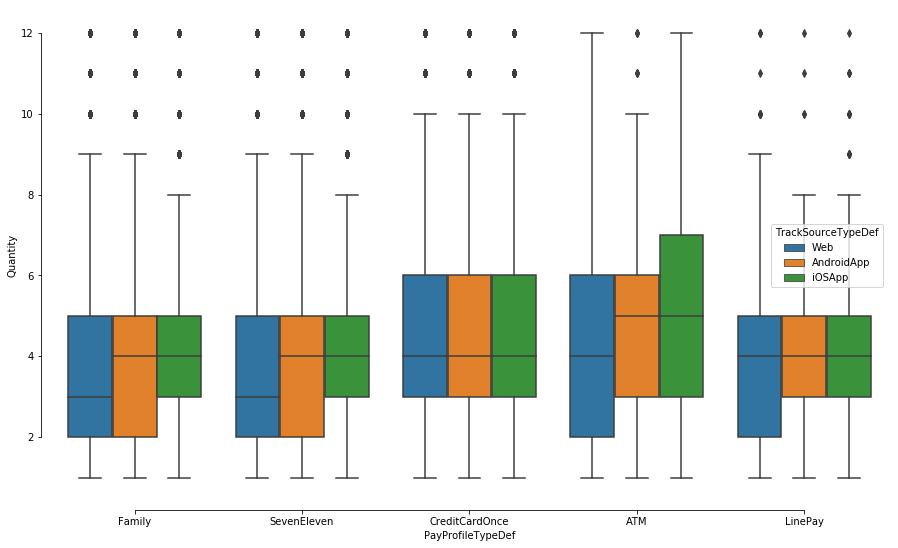

In [34]:
f, ax = plt.subplots(figsize=(15, 9))
sns.boxplot(x="PayProfileTypeDef", y="Quantity",
            hue="TrackSourceTypeDef", data=shopping_cart)
sns.despine(offset=10, trim=True)


## 不同付款方式與不同使用裝置，與總價格的關係

* 使用`Mobile`與`PC`裝置的顧客在購買總價格的差異較不明顯

* 使用`Pad`消費的顧客較少、購買總金額也較低

* 高總價的訂單與`ATM`付款呈現相關性

* 總價格比較: `ATM` > `CreditCard` > `LinePay` > `SevenEleven` = `Family`

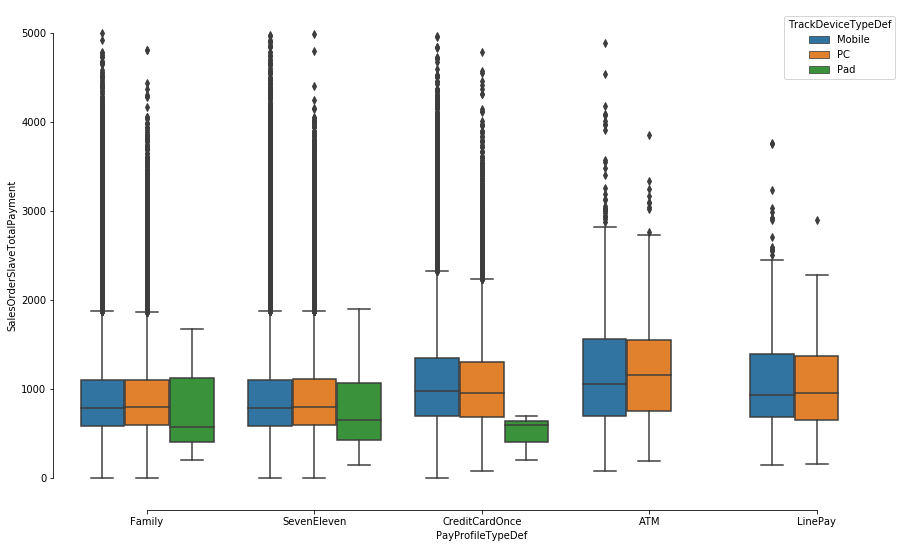

In [35]:
f, ax = plt.subplots(figsize=(15, 9))
sns.boxplot(x="PayProfileTypeDef", y="SalesOrderSlaveTotalPayment",
            hue="TrackDeviceTypeDef", data=shopping_cart)
sns.despine(offset=10, trim=True)


## 不同付款方式與不同使用裝置，與總數量的關係

* 使用`PC`裝置的顧客在購買商品的總數量略多於使用`Mobile`裝置的顧客

* 使用`Pad`消費的顧客較少、購買總數量也較少

* 多商品數量的訂單與`CreditCard`付款呈現相關性

* 總商品數量比較: `CreditCard` > `ATM` > `LinePay` > `SevenEleven` = `Family`

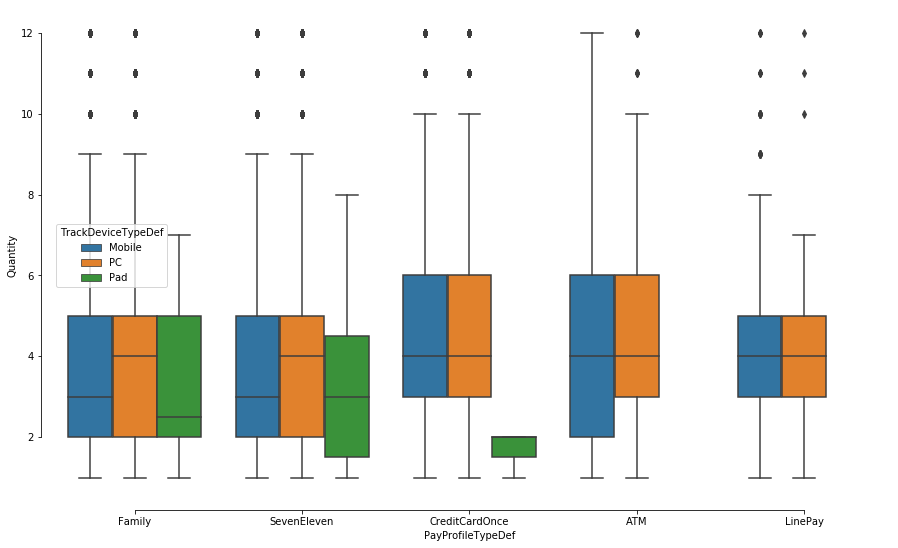

In [36]:
f, ax = plt.subplots(figsize=(15, 9))
sns.boxplot(x="PayProfileTypeDef", y="Quantity",
            hue="TrackDeviceTypeDef", data=shopping_cart)
sns.despine(offset=10, trim=True)


## 總價格與總數量的關係

* 依據回歸直線判斷，商品數量每增加一個，約可預期總價格增加300元

* 依據分布，大部分訂單的商品數量約為2~4個，總價格約為800元

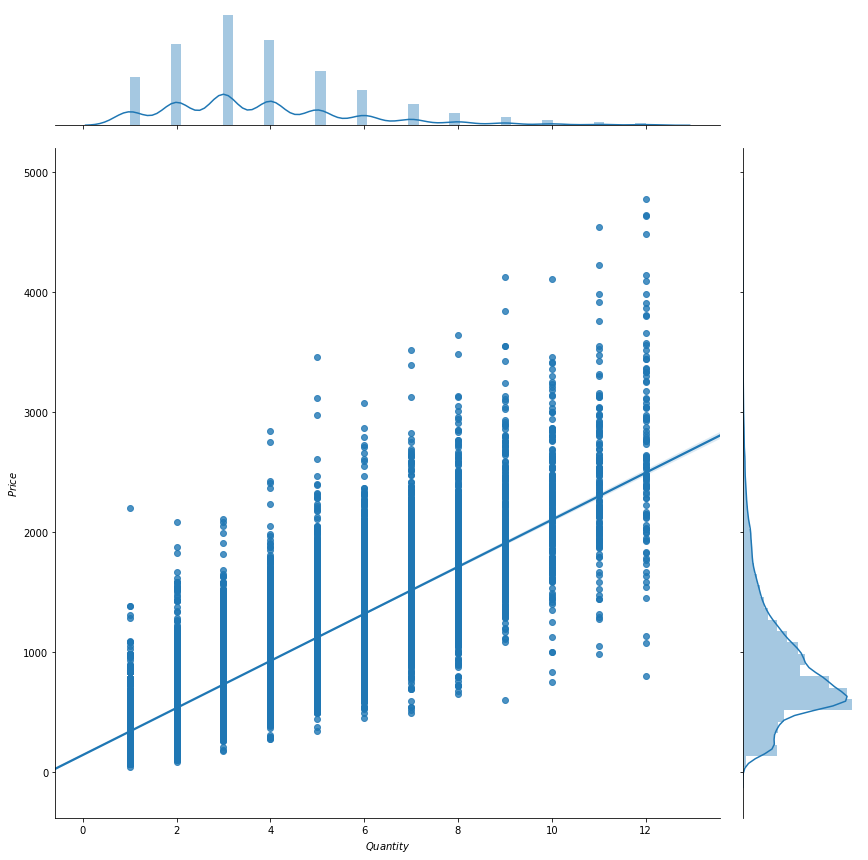

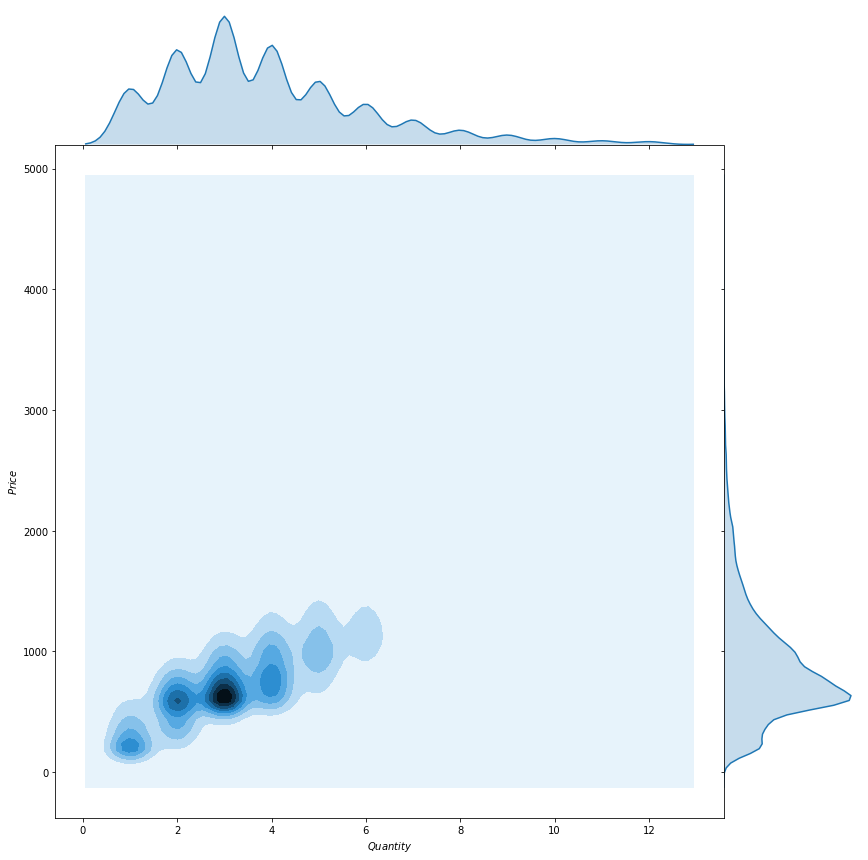

In [12]:
# 每台購物車
x = pd.to_numeric(shopping_cart["Quantity"].iloc[-20000:]).astype(int)
y = pd.to_numeric(shopping_cart["SalesOrderSlaveTotalPayment"].iloc[-20000:]).astype(int)
joint_reg_price_to_quantity = sns.jointplot(x=x, y=y, kind="reg", height=12).set_axis_labels("$Quantity$", "$Price$")
joint_kde_price_to_quantity = sns.jointplot(x=x, y=y, kind="kde", space=0, height=12).set_axis_labels("$Quantity$", "$Price$")


## ShoppingCarts.csv每月總營收

* 以一年為週期，可以發現每年 4, 5, 11, 12 月是商城旺季，1, 2 月是商城淡季

* 歷史最高銷售額紀錄分別出現在 2016 年 11 月和 2017 年 11 月

In [ ]:
# Revenue by month
shopping_cart["Month"] = shopping_cart["DateId"].values.astype("datetime64[M]").astype(str)
revenue_by_month = shopping_cart.groupby("Month", as_index = False).agg({"SalesOrderSlaveTotalPayment":"sum"})
data_revenue_by_month = [
    go.Bar(
        x=revenue_by_month["Month"], 
        y=revenue_by_month["SalesOrderSlaveTotalPayment"],
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5,
        )
    ),
    opacity=0.6
    )]
layout_revenue_by_month = go.Layout(
    title="Revenue by month",
    plot_bgcolor="rgba(245, 246, 249, 1)"
)
fig_revenue_by_month = go.Figure(data=data_revenue_by_month, layout=layout_revenue_by_month)
py.iplot(fig_revenue_by_month, filename="91APP_MonthlyRevenue", fileopt="extend")


D:\Program Files (x86)\Virtual_Environments\ENV\lib\site-packages\plotly\plotly\plotly.py:101: DeprecationWarning:

The fileopt parameter is deprecated and will be removed in plotly.py version 4

D:\Program Files (x86)\Virtual_Environments\ENV\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## ShoppingCarts.csv週間訂單數

* 週日、週三是一週內訂單數量較多的兩天

* 週五訂單數量最少

In [22]:
shopping_cart["DateId"] = pd.to_datetime(shopping_cart["DateId"].astype(str), format="%Y-%m-%d %H:%M:%S.%f")
shopping_cart["Day"] = shopping_cart["DateId"].dt.normalize().dt.day_name()
shopping_cart["Count"] = 1

orders_by_weekday = shopping_cart.groupby("Day", as_index=False).agg({"Count": "sum"})
category = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
orders_by_weekday["Day"] = pd.Categorical(orders_by_weekday["Day"], categories=category, ordered=True)
orders_by_weekday = orders_by_weekday.sort_values("Day")
orders_by_weekday_data = [
    go.Bar(
        x=orders_by_weekday["Day"],
        y=orders_by_weekday["Count"],
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5,
            )
        ),
        opacity=0.6  
    )
]
orders_by_weekday_layout = go.Layout(
    title="Orders count by day",
    plot_bgcolor="rgba(245, 246, 249, 1)"
)
orders_by_weekday_layout_fig = go.Figure(data=orders_by_weekday_data, layout=orders_by_weekday_layout)
py.iplot(orders_by_weekday_layout_fig, filename='orders_by_weekday')

## PromotionOrders.csv與TargetOrders.csv合併、清理、視覺化

* 合併訂單編號`SalesOrderSlaveId`與日期`DateId`

* 分析各優惠折扣`DiscountType`的歷史總使用次數

* 分析各優惠折扣`DiscountType`的每月使用次數

In [6]:
promotion_order = pd.read_csv("./Dataset/PromotionOrders.csv", dtype="unicode")
describe_pd_data(promotion_order)


Data columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011064 entries, 0 to 4011063
Data columns (total 13 columns):
SalesOrderSlaveId                               object
PromotionId                                     object
SalesOrderSlavePromotionDiscount                object
SalesOrderSlavePromotionDiscountAllocated       object
SalesOrderSlavePromotionDiscountAllocatedQty    object
SalesOrderSlavePromotionDiscountRate            object
DiscountType                                    object
PromotionCondition_DiscountPrice                object
PromotionCondition_DiscountRate                 object
PromotionCondition_TotalPrice                   object
PromotionCondition_TotalQty                     object
PromotionStartDateTime                          object
PromotionEndDateTime                            object
dtypes: object(13)
memory usage: 397.8+ MB
None
__________________________________________________________________
Data head:
  SalesOrderSlaveId PromotionId 

In [7]:
target_order = pd.read_csv("./Dataset/TargetOrders.csv", dtype="unicode")
describe_pd_data(target_order)


Data columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080742 entries, 0 to 4080741
Data columns (total 24 columns):
DateId                         object
MemberId                       object
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              object
SalePageId                     object
Quantity                       object
UnitPrice                      object
PromotionDiscount              object
ECouponId                      object
ECouponDiscount                object
SalesOrderSlaveTotalPayment    object
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           object
City                           object
District                       object
ZipCode                        object
StoreName                      object
StoreId                        object
DeliverTypeDef                 object
ReturnGoodsDateId              object

In [ ]:
target_promotion_order = promotion_order.merge(target_order[["SalesOrderSlaveId","DateId"]], on=["SalesOrderSlaveId"], how="left")
target_promotion_order = target_promotion_order.dropna(subset=["DateId"])
describe_pd_data(target_promotion_order)
target_promotion_order.to_csv("./Dataset/TargetPromotionOrders.csv", sep=",", encoding="utf-8", index=False)


In [8]:
target_promotion_order = pd.read_csv("./Dataset/TargetPromotionOrders.csv", dtype="unicode")
describe_pd_data(target_promotion_order)


Data columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976803 entries, 0 to 2976802
Data columns (total 14 columns):
SalesOrderSlaveId                               object
PromotionId                                     object
SalesOrderSlavePromotionDiscount                object
SalesOrderSlavePromotionDiscountAllocated       object
SalesOrderSlavePromotionDiscountAllocatedQty    object
SalesOrderSlavePromotionDiscountRate            object
DiscountType                                    object
PromotionCondition_DiscountPrice                object
PromotionCondition_DiscountRate                 object
PromotionCondition_TotalPrice                   object
PromotionCondition_TotalQty                     object
PromotionStartDateTime                          object
PromotionEndDateTime                            object
DateId                                          object
dtypes: object(14)
memory usage: 318.0+ MB
None
_______________________________________________________

## 各優惠折扣歷史總使用次數

* 轉換折扣類型`DiscountType`名稱

* 以個別顏色區分折扣類型`DiscountType_Eng`

* 各折扣的歷史使用次數由多到少排序為: 滿額折現`Cash with Purchase` > 滿額贈`Gift with Purchase`> 任選優惠價`Discount given Selection` > 滿件打折`Discount with Amount Purchase` > 滿額打折`Discount with Purchase` > 會員滿額打折`Member Discount` > 滿件折現`Cash with Amount Purchase`

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

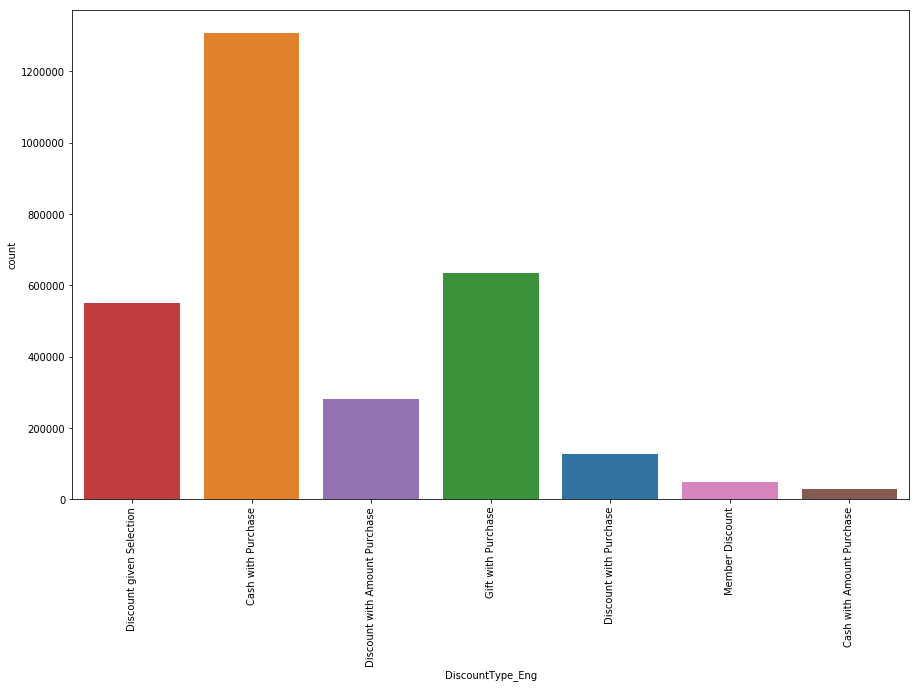

In [38]:
target_promotion_order["DiscountType_Eng"] = target_promotion_order["DiscountType"].replace({
    '滿額打折': 'Discount with Purchase',
    '滿額折現': 'Cash with Purchase',
    '滿額贈': 'Gift with Purchase',
    '任選優惠價': 'Discount given Selection', 
    '滿件打折': 'Discount with Amount Purchase',
    '滿件折現': 'Cash with Amount Purchase', 
    '會員滿額打折': 'Member Discount'
    })

palette = {
    "Discount with Purchase":"C0","Cash with Purchase":"C1","Gift with Purchase":"C2",
    "Discount given Selection":"C3","Discount with Amount Purchase":"C4","Cash with Amount Purchase":"C5",
    "Member Discount":"C6"
}

f, ax = plt.subplots(figsize=(15, 9))
sns.countplot(x="DiscountType_Eng", data=target_promotion_order, palette=palette)
plt.xticks(rotation=90)


## 各優惠折扣每月使用次數

* 2016 年 8 月以前多以任選優惠價`Discount given Selection`方式促銷

* 2016 年 9 月後滿額折現`Cash with Purchase`為促銷主要手段

* 2017 年 4 月到年底期間滿額贈`Gift with Purchase`佔有一定的比例

* 2018 年開始重新選定了促銷策略，以滿件打折`Discount with Amount Purchase`為大宗

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

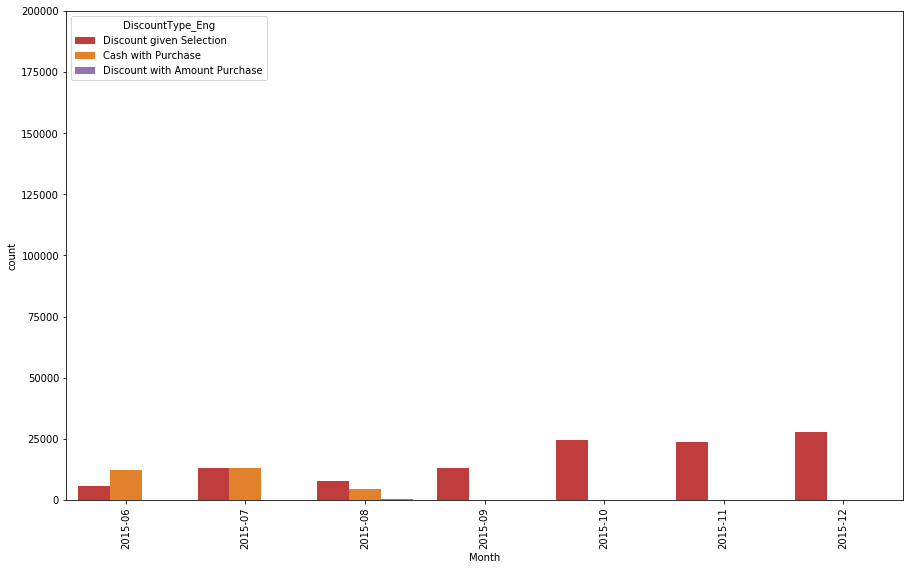

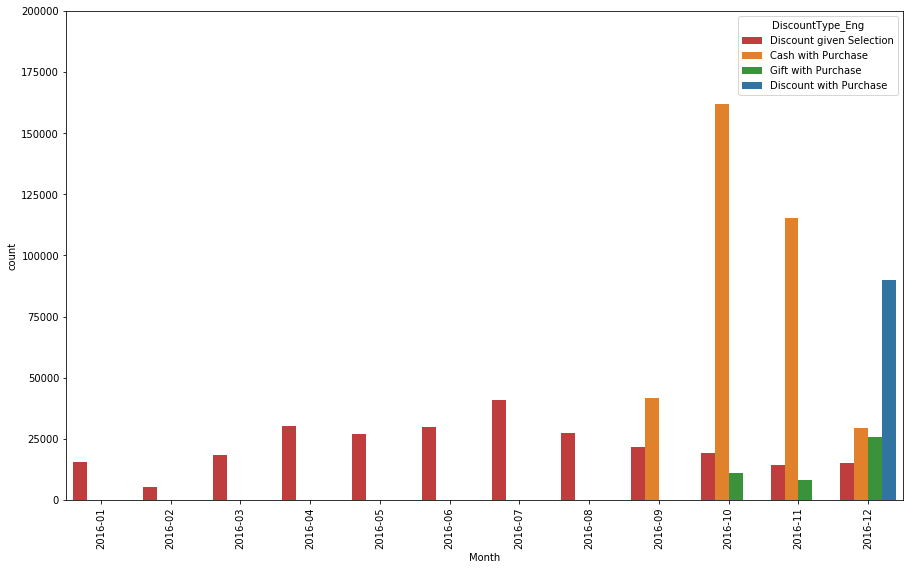

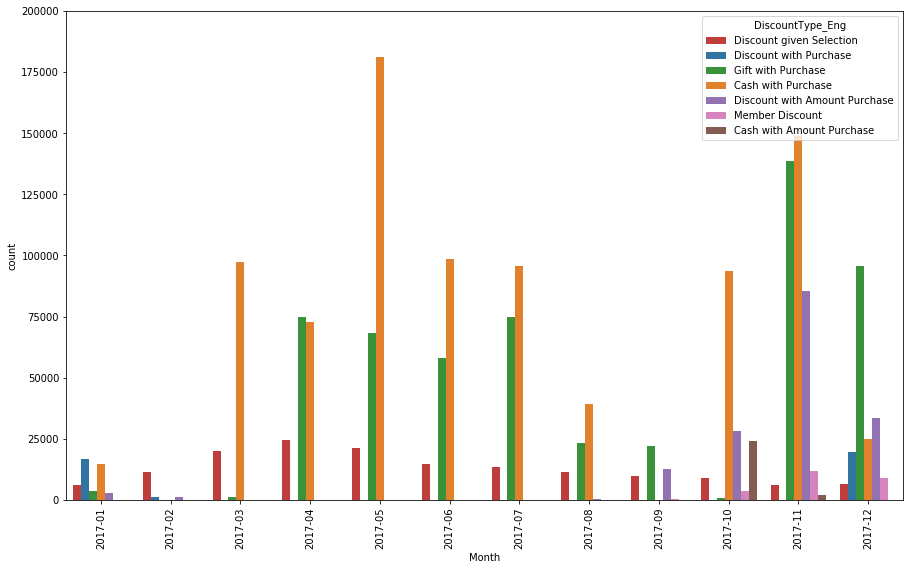

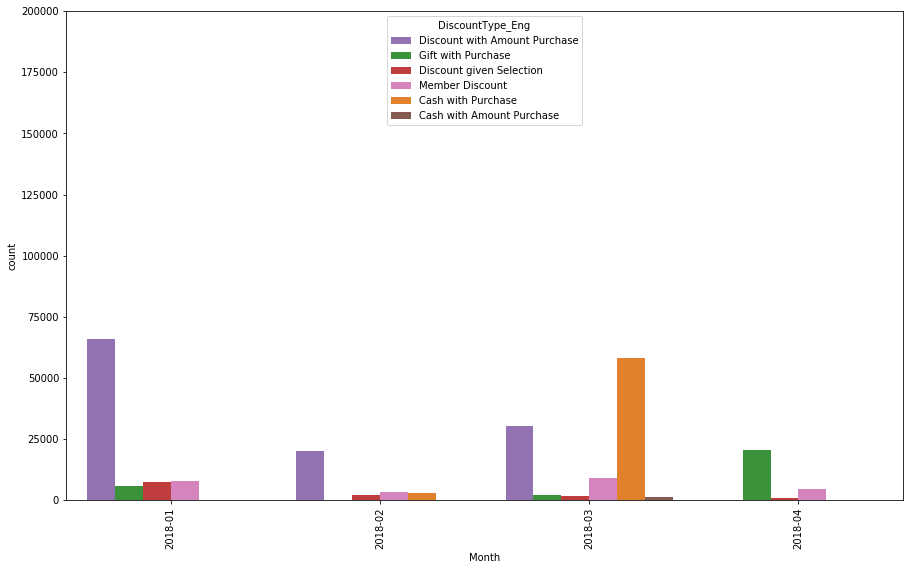

In [40]:
# Promotion by month
target_promotion_order["DateId"] = pd.to_datetime(target_promotion_order["DateId"].astype(str), format="%Y-%m-%d %H:%M:%S.%f")
target_promotion_order = target_promotion_order.sort_values(by=["DateId"])
target_promotion_order["Month"] = target_promotion_order["DateId"].values.astype("datetime64[M]").astype(str)
target_promotion_order["Count"] = 1 
promotion_by_month_2015 = target_promotion_order.loc[target_promotion_order["Month"].str.contains("2015")]
promotion_by_month_2016 = target_promotion_order.loc[target_promotion_order["Month"].str.contains("2016")]
promotion_by_month_2017 = target_promotion_order.loc[target_promotion_order["Month"].str.contains("2017")]
promotion_by_month_2018 = target_promotion_order.loc[target_promotion_order["Month"].str.contains("2018")]

f, ax = plt.subplots(figsize=(15, 9))
sns.countplot(x="Month", hue="DiscountType_Eng", data=promotion_by_month_2015, palette=palette)
plt.ylim(0, 200000)
plt.xticks(rotation=90)

f, ax = plt.subplots(figsize=(15, 9))
sns.countplot(x="Month", hue="DiscountType_Eng", data=promotion_by_month_2016, palette=palette)
plt.ylim(0, 200000)
plt.xticks(rotation=90)

f, ax = plt.subplots(figsize=(15, 9))
sns.countplot(x="Month", hue="DiscountType_Eng", data=promotion_by_month_2017, palette=palette)
plt.ylim(0, 200000)
plt.xticks(rotation=90)

f, ax = plt.subplots(figsize=(15, 9))
sns.countplot(x="Month", hue="DiscountType_Eng", data=promotion_by_month_2018, palette=palette)
plt.ylim(0, 200000)
plt.xticks(rotation=90)